In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import seaborn as sns
import sys

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import pathhelper

In [2]:
out_dir = pathhelper.git_root(".") / "output"
data_dir = pathhelper.data_dir(".")
at_filename = data_dir / "pedestrians_cyclists/Trails_Counters_Pedestrians_Cyclists-hourly.feather"
weather_filename = data_dir / "weather/en_climate_hourly_ON_6144239_concat.feather"

# Load data

In [3]:
hourly_full_df = pd.read_feather(at_filename)
weather_full_df = pd.read_feather(weather_filename)

In [4]:
# ---- Active Transportation Counters

# Create site categorical encoding
site_cats_acc = hourly_full_df["site_name"].astype('category').cat
site_codes = site_cats_acc.codes.unique()
site_cats = site_cats_acc.categories
hourly_full_df["site_name_cat"] = site_cats_acc.codes
hourly_full_df["user_type_cat"] = hourly_full_df["user_type"].astype("category").cat.codes
hourly_full_df["direction_cat"] = hourly_full_df["direction"].astype("category").cat.codes

hourly_full_df.drop(labels=["flow_id", "flow_name"], axis=1, inplace=True, errors='ignore')

# ---- Weather
weather_full_df.columns = weather_full_df.columns.str.lower()
weather_full_df["hour"]=weather_full_df["time (lst)"].str[0:2].astype(int)
weather_full_df["weather_cat"] = weather_full_df["weather"].astype("category").cat.codes


In [5]:
hourly_full_df.dtypes

site_name         object
site_id            int64
user_type         object
direction         object
year               int64
month              int64
day                int64
hour               int64
count            float64
dayofweek          int32
week              UInt32
site_name_cat       int8
user_type_cat       int8
direction_cat       int8
dtype: object

In [6]:
weather_full_df.dtypes

longitude (x)          float64
latitude (y)           float64
station name            object
climate id               int64
date/time (lst)         object
year                     int64
month                    int64
day                      int64
time (lst)              object
temp (°c)              float64
temp flag               object
dew point temp (°c)    float64
dew point temp flag     object
rel hum (%)            float64
rel hum flag            object
precip. amount (mm)    float64
precip. amount flag     object
wind dir (10s deg)     float64
wind dir flag           object
wind spd (km/h)        float64
wind spd flag           object
visibility (km)        float64
visibility flag         object
stn press (kpa)        float64
stn press flag          object
hmdx                   float64
hmdx flag              float64
wind chill             float64
wind chill flag        float64
weather                 object
hour                     int64
weather_cat               int8
dtype: o

# Select range

- Iron Horse Trail - Cherry Street
- 2018

In [7]:
at_df = hourly_full_df[hourly_full_df["year"] == 2018]
at_df = at_df[at_df["site_name"] == "Iron Horse Trail - Cherry Street"]

In [8]:
df = at_df.groupby(["year", "month", "day", "hour", "dayofweek", "week", "direction_cat", "user_type"])["count"].sum()
df = df.unstack().reset_index()
#df

In [9]:
weather_df = weather_full_df[weather_full_df["year"] == 2018]
weather_df = weather_df.set_index(["year", "month", "day", "hour"])
len(weather_df)

8760

In [10]:
df = df.join(weather_df, on=["year", "month", "day", "hour"])

# Quality checks

In [11]:
temp_flag = int(df["temp flag"].notnull().sum())
dew_point_temp_flag = int(df["dew point temp flag"].notnull().sum())
rel_hum_flag = int(df["rel hum flag"].notnull().sum())
precip_amount_flag = int(df["precip. amount flag"].notnull().sum())
wind_dir_flag = int(df["wind dir flag"].notnull().sum())
wind_spd_flag = int(df["wind spd flag"].notnull().sum())
visibility_flag = int(df["visibility flag"].notnull().sum())
stn_press_flag = int(df["stn press flag"].notnull().sum())
hmdx_flag = int(df["hmdx flag"].notnull().sum())
wind_chill_flag = int(df["wind chill flag"].notnull().sum())

print(f"{temp_flag=}")
print(f"{dew_point_temp_flag=}")
print(f"{rel_hum_flag=}")
print(f"{precip_amount_flag=}")
print(f"{wind_dir_flag=}")
print(f"{wind_spd_flag=}")
print(f"{visibility_flag=}")
print(f"{stn_press_flag=}")
print(f"{hmdx_flag=}")
print(f"{wind_chill_flag=}")

temp_flag=0
dew_point_temp_flag=0
rel_hum_flag=0
precip_amount_flag=0
wind_dir_flag=660
wind_spd_flag=2
visibility_flag=16
stn_press_flag=0
hmdx_flag=0
wind_chill_flag=0


In [12]:
features_at=[
    "year",
    "month",
    "day",
    "hour",
    "dayofweek",
    "week",
    "direction_cat",
]
features_weather=[
    "temp (°c)",
    "dew point temp (°c)",
    "rel hum (%)",
    "precip. amount (mm)",
    "wind dir (10s deg)",
    "wind spd (km/h)",
    "visibility (km)",
    "stn press (kpa)",
    #"hmdx", # too many null
    "wind chill",
    "weather_cat",
]
features = features_at+features_weather

y_cyclist = df["Cyclist"]
y_pedestrian = df["Pedestrian"]
X = df[features]
Xy = df[features+["Cyclist", "Pedestrian"]]

# Feature pairs

See [dev_features_importance](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html)

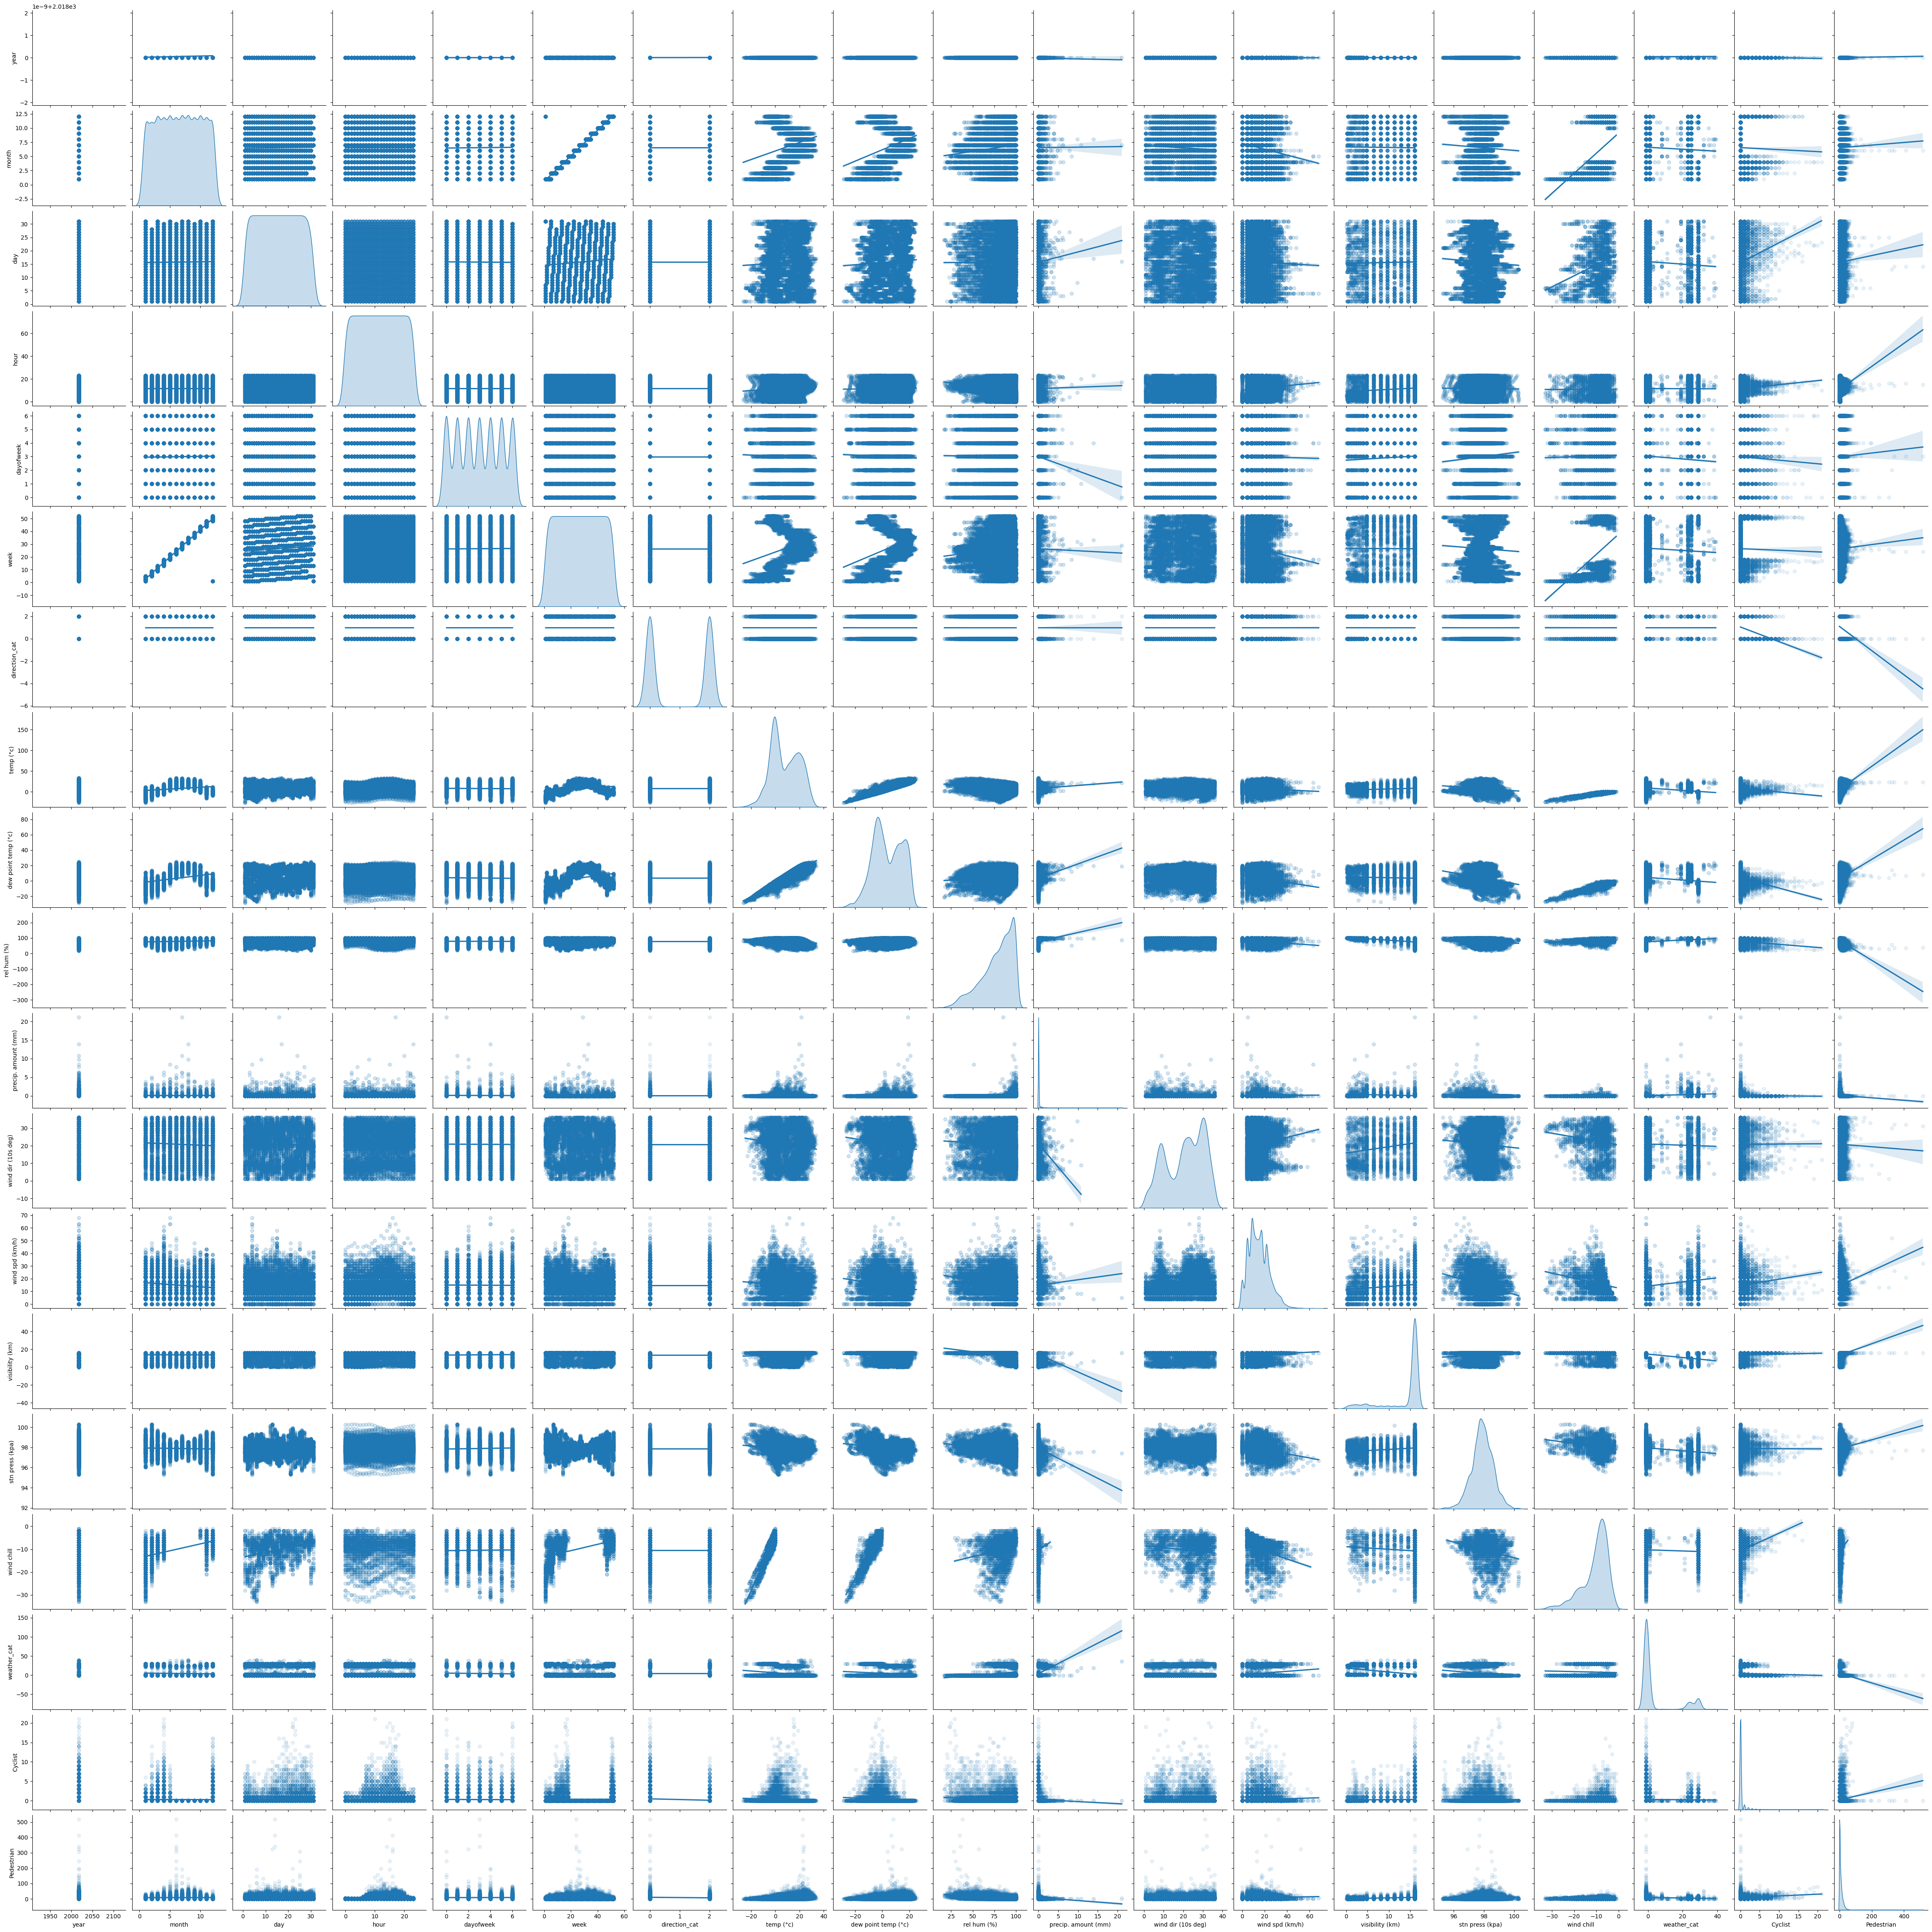

In [13]:
_ = sns.pairplot(
    Xy,
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

# Random Forest

See [plot_forest_importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [14]:
forest_cyclist = RandomForestRegressor(max_depth=2, random_state=0)
forest_cyclist.fit(X, y_cyclist)

forest_pedestrian = RandomForestRegressor(max_depth=2, random_state=0)
forest_pedestrian.fit(X, y_pedestrian)

RandomForestRegressor(max_depth=2, random_state=0)

# Feature Importance: Random Forest

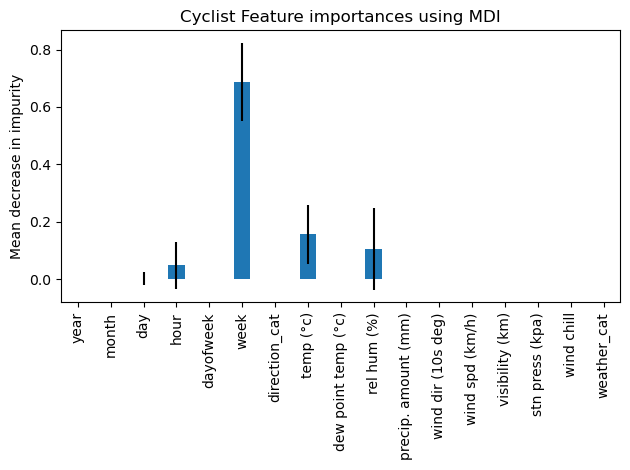

In [15]:
def rf_importance_mdi(forest, title=None):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=features)
    
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    title = title + " " or ""
    ax.set_title(f"{title}Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    fig.show()

rf_importance_mdi(forest_cyclist, title="Cyclist")


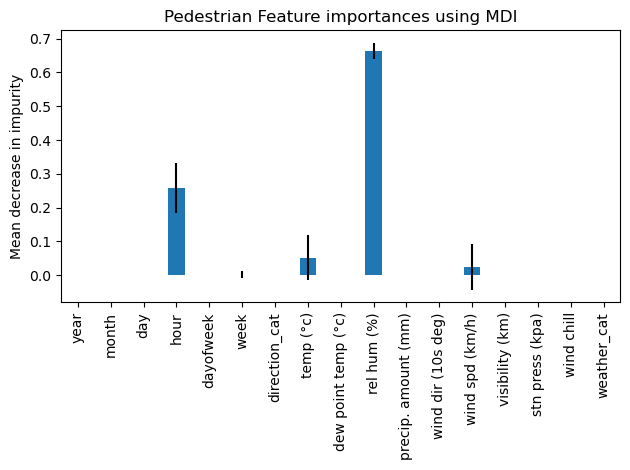

In [16]:
rf_importance_mdi(forest_pedestrian, title="Pedestrian")

# Feature Imortance: Logistic Regression

See: https://forecastegy.com/posts/feature-importance-in-logistic-regression/

In [17]:
Xnn = Xy.copy()
#Xnn["y_pedestrian"] = y_pedestrian
#Xnn["y_cyclist"] = y_cyclist
Xnn = Xy.dropna()

y_pedestrian = Xnn["Pedestrian"]
y_cyclist = Xnn["Cyclist"]
Xnn = Xnn.drop(["Pedestrian", "Cyclist"], axis=1)

In [18]:
lr_pedestrian = LogisticRegression()
lr_pedestrian.fit(Xnn, y_pedestrian)

lr_cyclist = LogisticRegression()
lr_cyclist.fit(Xnn, y_cyclist)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression()

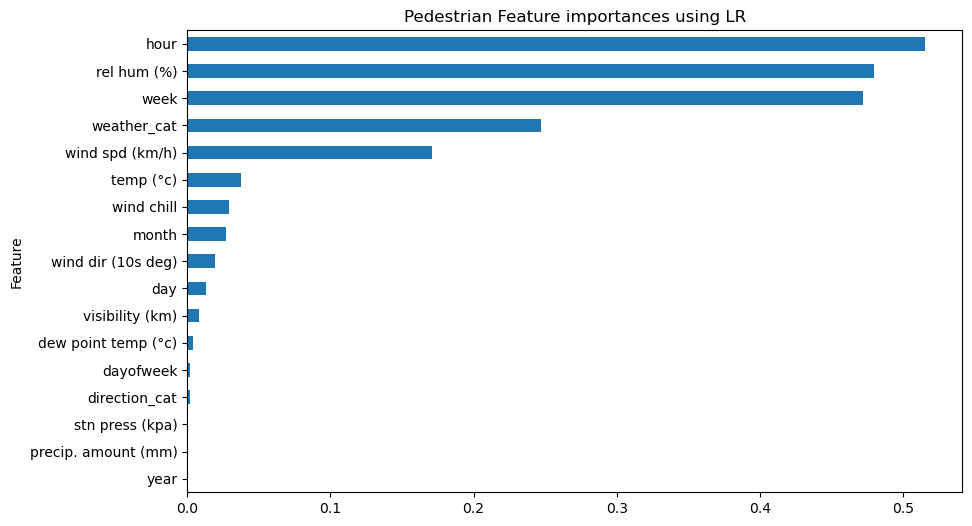

In [19]:
def lr_importance(model, X, title=None):
    Xstd = np.std(X, 0)
    coefficients = Xstd.to_numpy() * model.coef_[0]

    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    ax.get_legend().remove()
    title = title + " " or ""
    ax.set_title(f"{title}Feature importances using LR")

lr_importance(lr_pedestrian, Xnn, title="Pedestrian")

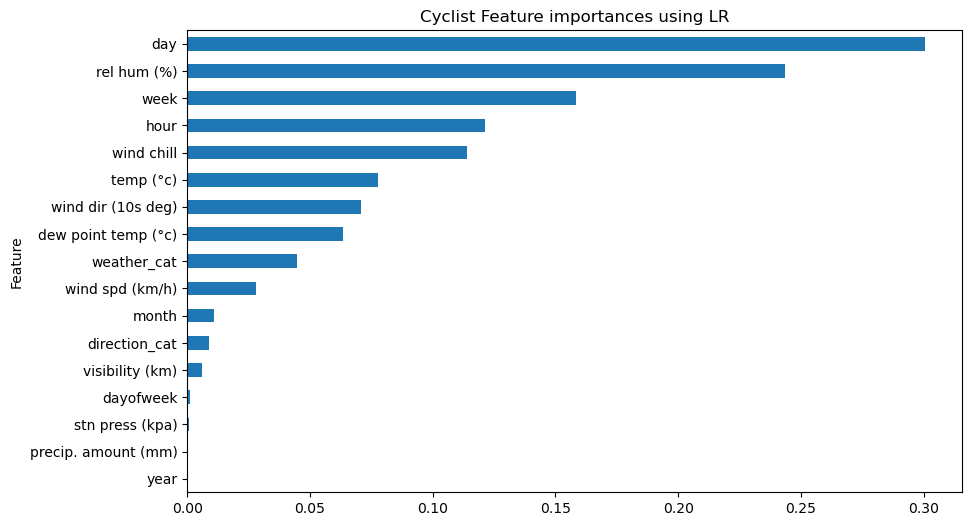

In [20]:
lr_importance(lr_cyclist, Xnn, title="Cyclist")